# Identify player interactions

This is an example for one slice of data. This file does the following:
    1. read map data 
    2. identify player interactions based on if they have interacted with the same objects
    3. generate a directed weighted graph of player interactions for each family
    4. calculate some summary statistics for player interactions
    
Created by Grace Deng in April, 2021

In [4]:
import os, re, glob, datetime, json
import pandas as pd
import numpy as np
import scipy.stats
from datetime import datetime

from tqdm.notebook import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

## Sort map data

In [56]:
#change this
baseDir = '../../OneHourOneLife/data/publicMapChangeData/bigserver2.onehouronelife.com/'

In [53]:
int_extract = lambda pattern, s: int(re.search(pattern, s).group(0))

In [58]:
file_names = []
for ts in glob.glob(baseDir + '*'):
    fn = ts.split('/')[-1]
    file_names.append(fn)
    
file_names.sort(key=lambda f: int_extract('[0-9]+(?=)', f))
map_seeds = [int_extract('[0-9]+(?=)', fn) for fn in file_names if 'mapSeed' in fn]
print("Looking at mapSeeds: ", map_seeds)

Looking at mapSeeds:  [1573895673, 1574102503, 1576038671, 1578345720, 1578354747, 1579713519, 1580144896, 1581985139, 1583642903, 1584061484, 1585440511, 1585512770, 1585603481, 1587166656]


In [59]:
(1587166656 - 1573895673)/60/60/24

153.59934027777777

In [60]:
file_dict = {}
for fn in file_names:
    timestamp = int_extract('[0-9]+(?=)', fn)
    if timestamp in map_seeds:
        map_start = timestamp
        file_dict[map_start] = [timestamp]
    else:
        file_dict[map_start].append(timestamp)

In [61]:
subset = file_dict[list(file_dict.keys())[4]]
print("Now parseing mapChange data: ", subset)

Now parseing mapChange data:  [1578354747, 1578441147, 1578527547, 1578610753, 1578697153, 1578783553, 1578869953, 1578956353, 1579042753, 1579129153, 1579215554, 1579301954, 1579302774, 1579389174, 1579475574, 1579561975, 1579648375]


## Read map data

In [62]:
start = pd.read_csv(baseDir + str(subset[0]) + 'time_mapLog.txt')
time0 = float(start.columns[0].split(": ")[1])

In [256]:
time0

1578354746.65

In [14]:
col = ['time','locX','locY','obj','playerID']
data = pd.DataFrame(columns = col)
for i in tqdm(subset):
    mydf = pd.read_csv(baseDir + str(i) + 'time_mapLog.txt')
    start_time = float(mydf.columns[0].split(": ")[1])
    mydf[['time','locX','locY','obj','playerID']] = mydf[mydf.columns[0]].str.split(" ", expand=True)
    mydf = mydf.dropna()
    mydf['time'] = mydf['time'].astype(float) + start_time - time0
    mydf['playerID'] = mydf['playerID'].astype(int)
    mydf = mydf[col]
    data = data.append(mydf, ignore_index = True)

A Jupyter Widget

In [15]:
# data.to_csv('outputs/data_slice4.csv')
len(data)

26472119

In [8]:
# data = pd.read_csv('data_slice4.csv', index_col=[0])
data.head()

,time,locX,locY,obj,playerID
0,10.88,48,-217,48,2535863
1,12.38,50,-215,64,2535863
2,54.61,5400120,3,0,-1
3,54.61,5400121,3,0,-1
4,54.61,5400122,3,530,-1


In [18]:
len(data.loc[data.playerID==-1])

11561845

## tag player by family

In [9]:
#pull this from database
fam= pd.read_csv('../OneHourOneLife/2_demographics/outputs/family_playerID.tsv', sep = '\t', index_col = 0)

/Users/dengwenning/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
fam.head()

,playerID,family
0,3080084,time-1592284232_eve-3080067_name-PICKLE
1,3080114,time-1592284232_eve-3080067_name-PICKLE
2,3080111,time-1592284232_eve-3080067_name-PICKLE
3,3080108,time-1592284232_eve-3080067_name-PICKLE
4,3080104,time-1592284232_eve-3080067_name-PICKLE


In [11]:
#remove natural transitions
with_family = data.loc[data.playerID != -1]
with_family = pd.merge(with_family, fam, how='left')

In [12]:
with_family.head()

,time,locX,locY,obj,playerID,family
0,10.88,48,-217,48,2535863,time-1578354755_eve-2535863_name-ORACION
1,12.38,50,-215,64,2535863,time-1578354755_eve-2535863_name-ORACION
2,61.11,5400013,-2,878,2535866,NaN
3,92.74,6,-198,161,2535865,NaN
4,99.45,5400127,0,879,2535866,NaN


In [38]:
len(with_family)

14910274

Genrate some summary statistics for each family

In [14]:
grouped = with_family.groupby(['family','playerID'], as_index=False)['time'].count()

In [64]:
time = with_family.groupby(['family'])['time'].max().to_frame().reset_index()
time['start_time'] = time['family'].apply(lambda x: int_extract('[0-9]+', x.split('_')[0])) - time0
time['duration'] = time['time'] - time['start_time']

In [65]:
num_interactions = grouped.groupby(['family'])['time'].sum().to_frame().reset_index()
num_players = grouped.groupby(['family'])['playerID'].count().to_frame().reset_index()

In [66]:
fam_stats = pd.merge(num_players, num_interactions, on='family')
fam_stats = pd.merge(fam_stats, time[['family','duration']], on='family')
fam_stats = fam_stats.rename({'playerID':'num_players', 'time':'num_interactions'},axis=1)

In [67]:
fam_stats.head()

,family,num_players,num_interactions,duration
0,time-1578354755_eve-2535863_name-ORACION,125,37739,16934.57
1,time-1578354812_eve-2535868_name-KIRSCHBAUM,461,175127,72630.68
2,time-1578354869_eve-2535872_name-BERNIE,24,7136,6166.84
3,time-1578354889_eve-2535874_name-AGNOS,2,362,1326.67
4,time-1578354953_eve-2535878_name-AUCK,3,289,1062.13


How many families are there?

In [176]:
len(fam_stats)

392

## Draw Edges

sort by location and time and shift the player column

In [15]:
loc_data = with_family.sort_values(by = ['locX','locY','time'])
loc_data['same_loc'] =loc_data.locY.eq(data.locY.shift())

In [16]:
loc_data['prev_obj'] = loc_data.obj.shift()
loc_data['prev_playerID'] = loc_data.playerID.shift()
loc_data['prev_player_fam'] = loc_data.family.shift()

In [17]:
loc_data.head(n=10)

,time,locX,locY,obj,playerID,family,same_loc,prev_obj,prev_playerID,prev_player_fam
13528731,1194064.77,-43877,-640,242,2601997,NaN,False,NaN,NaN,NaN
13528756,1194067.11,-43871,-639,223,2601997,NaN,False,242,2601997.0,NaN
13529302,1194113.20,-43827,-640,87,2601997,NaN,False,223,2601997.0,NaN
14207003,1271819.24,-34984,-20897,404,2605158,time-1579625506_eve-2605158_name-TELA,False,87,2601997.0,NaN
14206995,1271818.86,-34982,-20897,2745u3,2605158,time-1579625506_eve-2605158_name-TELA,False,404,2605158.0,time-1579625506_eve-2605158_name-TELA
14207004,1271819.49,-34982,-20897,2745,2605158,time-1579625506_eve-2605158_name-TELA,False,2745u3,2605158.0,time-1579625506_eve-2605158_name-TELA
14207007,1271819.79,-34982,-20897,0,2605158,time-1579625506_eve-2605158_name-TELA,False,2745,2605158.0,time-1579625506_eve-2605158_name-TELA
14206961,1271816.31,-34982,-20893,2745u2,2605158,time-1579625506_eve-2605158_name-TELA,False,0,2605158.0,time-1579625506_eve-2605158_name-TELA
14206973,1271816.94,-34982,-20893,2745u3,2605158,time-1579625506_eve-2605158_name-TELA,False,2745u2,2605158.0,time-1579625506_eve-2605158_name-TELA
14206975,1271817.26,-34982,-20893,0,2605158,time-1579625506_eve-2605158_name-TELA,False,2745u3,2605158.0,time-1579625506_eve-2605158_name-TELA


In [ ]:
#weight graph by number of interactions
#tfidf term freq inverse document freq, weight the word by how often it occurs. how much more A interacted with B 

In [276]:
len(loc_data)

14910274

Filter out some conditions

In [18]:
#exclusion: 
#1) one player turned a location to an empty groud and another player put smth on it.
#2) excluding self-edge
#3&4) natural things
#5) not the same item
conn_data = loc_data.loc[(loc_data.prev_obj != "0") & \
                        (loc_data.playerID != loc_data.prev_playerID)& \
                        (loc_data.prev_playerID != -1) & \
                        (loc_data.playerID != -1) & \
                        (loc_data.same_loc==True)]

In [19]:
conn_data = conn_data[['time','locX','locY','prev_obj','obj','prev_playerID','playerID','family','prev_player_fam']]
conn_data = conn_data.sort_values(by='time').rename({'family':'player_fam'},axis=1)

In [20]:
len(conn_data)

4128

In [21]:
conn_data.head()

,time,locX,locY,prev_obj,obj,prev_playerID,playerID,player_fam,prev_player_fam
4821,1091.78,3,-277,248,234,2535877.0,2535919,time-1578354755_eve-2535863_name-ORACION,time-1578354755_eve-2535863_name-ORACION
5506,1174.62,-400,40,292,1096u0,2536210.0,2535890,time-1578355044_eve-2535884_name-VADO,time-1578355044_eve-2535884_name-VADO
5607,1185.38,-402,40,235,0,2535890.0,2535884,time-1578355044_eve-2535884_name-VADO,time-1578355044_eve-2535884_name-VADO
5620,1187.07,5400162,40,30u2,292,2596915.0,2535932,NaN,NaN
5657,1191.12,-400,40,1096u2,1096u1,2535890.0,2535884,time-1578355044_eve-2535884_name-VADO,time-1578355044_eve-2535884_name-VADO


In [22]:
conn_data = conn_data.dropna() #drop players without a family?

In [72]:
conn_data.to_csv('outputs/conn_data_slice4.csv')

In [23]:
len(conn_data.loc[conn_data.prev_player_fam==conn_data.player_fam])

1512

## Graph

In [28]:
def build_graph(fam_data):
    weighted_edges = fam_data[['prev_playerID', 'playerID', 'time']].to_records(index=False)
    G = nx.DiGraph()
    G.add_weighted_edges_from(weighted_edges) 
    return G

In [29]:
def draw_graphs(conn_data):
    for i, fam in enumerate(conn_data.player_fam.unique()):
        fam_data = conn_data.loc[conn_data.player_fam==fam]
        G = build_graph(fam_data)
        plt.figure(figsize=(10,10))
        pos = nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos, node_size=25)
        nx.draw_networkx_edges(G, pos)
        plt.title(fam)
    plt.show()

## Analyze network properties

In [42]:
def analyze_nx_properties(fam):
    fam_data = conn_data.loc[conn_data.player_fam==fam]
    G = build_graph(fam_data)
    #number of nodes(avatars) in a family network
    nx_size = len(G)
    #mean degrees
    mean_deg = len(G.edges())/nx_size
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    #size of the largest component
    gc_size = len(largest_cc)
    return mean_deg, nx_size, gc_size

In [48]:
interaction_stats = pd.DataFrame(columns = ['family', 'start_time','mean_degree', 'nx_size', 'gc_size'])
for fam in conn_data.player_fam.unique():
    start_time = fam.split('_')[1].split('-')[1]
    mean_deg, nx_size, gc_size = analyze_nx_properties(fam)
    interaction_stats = interaction_stats.append({'family':fam, 'start_time': start_time, 'mean_degree':mean_deg,\
                        'nx_size':nx_size, 'gc_size': gc_size}, ignore_index = True)

In [49]:
interaction_stats = interaction_stats.sort_values(by='start_time')
interaction_stats.head()

,family,start_time,mean_degree,nx_size,gc_size
0,time-1578354755_eve-2535863_name-ORACION,2535863,0.905660,53,21
2,time-1578354812_eve-2535868_name-KIRSCHBAUM,2535868,0.853211,109,22
4,time-1578354869_eve-2535872_name-BERNIE,2535872,0.666667,12,5
1,time-1578355044_eve-2535884_name-VADO,2535884,0.750000,4,4
5,time-1578355178_eve-2535895_name-NAVIA,2535895,0.666667,3,3


In [68]:
full_data = pd.merge(interaction_stats, fam_stats, on='family', how='left')
full_data.head()

,family,start_time,mean_degree,nx_size,gc_size,num_players,num_interactions,duration
0,time-1578354755_eve-2535863_name-ORACION,2535863,0.905660,53,21,125,37739,16934.57
1,time-1578354812_eve-2535868_name-KIRSCHBAUM,2535868,0.853211,109,22,461,175127,72630.68
2,time-1578354869_eve-2535872_name-BERNIE,2535872,0.666667,12,5,24,7136,6166.84
3,time-1578355044_eve-2535884_name-VADO,2535884,0.750000,4,4,12,1977,3736.80
4,time-1578355178_eve-2535895_name-NAVIA,2535895,0.666667,3,3,20,3596,4795.06


In [70]:
edges = conn_data.groupby('player_fam')['time'].count().to_frame().reset_index()
m = pd.merge(edges, full_data, how='right', left_on = 'player_fam', right_on ='family')
full_data['sum_degree'] = m['time']

In [72]:
full_data['frac_gcc'] = full_data['gc_size']/full_data['num_players']
full_data['avg_interactions'] = full_data['num_interactions']/full_data['num_players']

In [73]:
full_data.sort_values(by='duration', ascending=False)
full_data = full_data.loc[full_data.num_players>1] #get rid of singletons

,family,start_time,mean_degree,nx_size,gc_size,num_players,num_interactions,duration,sum_degree,frac_gcc,avg_interactions
104,time-1579308538_eve-2588152_name-SAULER,2588152,0.696517,201,40,1709,539687,203866.06,140,0.0234055,315.791106
105,time-1579512354_eve-2600506_name-MEGALE,2600506,0.677419,93,12,1144,412772,201164.84,65,0.0104895,360.814685
30,time-1578628249_eve-2550315_name-COCK,2550315,0.545455,33,4,894,285603,181928.50,18,0.00447427,319.466443
103,time-1579306751_eve-2587939_name-CONNELL,2587939,0.537313,67,3,1163,391747,134617.13,37,0.00257954,336.841788
16,time-1578427637_eve-2540129_name-HEAVEN,2540129,0.680000,150,15,854,321063,125897.04,102,0.0175644,375.951991
62,time-1578887090_eve-2567082_name-NEPTUNE,2567082,0.695122,82,15,523,210033,100704.18,58,0.0286807,401.592734
59,time-1578865874_eve-2565293_name-FIRE,2565293,0.669231,130,9,500,157601,81701.21,88,0.018,315.202000
31,time-1578650048_eve-2551356_name-OAK,2551356,0.500000,8,2,451,148769,77929.43,4,0.00443459,329.864745
11,time-1578371964_eve-2537285_name-THE,2537285,0.775510,147,27,392,152925,74978.00,115,0.0688776,390.114796
44,time-1578783588_eve-2559680_name-STRONG,2559680,0.593750,32,4,321,114485,74764.30,20,0.0124611,356.651090


In [250]:
# full_data.to_csv('nx_data_slice4.csv')

## Visualize Correlations

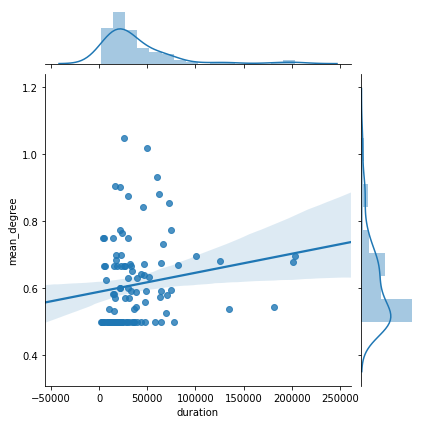

In [76]:
sns.jointplot(data =full_data, y='mean_degree', x='duration', kind='reg')
plt.show()

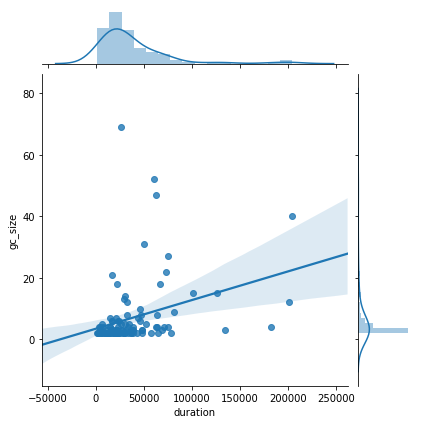

In [79]:
full_data['gc_size'] = full_data['gc_size'].astype('int32')
sns.jointplot(data =full_data, y='gc_size',x='duration', kind='reg')
plt.show()